1. Preprocess
2. Data Loader
3. Model define

# LSTM

* https://github.com/SheezaShabbir/Time-series-Analysis-using-LSTM-RNN-and-GRU/blob/main/Pytorch_LSTMs%2CRNN%2CGRU_for_time_series_data.ipynb
* https://github.com/vincrichard/LSTM-AutoEncoder-Unsupervised-Anomaly-Detection/blob/master/DataChallengeReport_VincentRichard.ipynb
* https://github.com/yakhyo/pytorch-tutorials/blob/main/tutorials/03-intermediate/04-lstm-network/main.py
* https://github.com/yakhyo/pytorch-tutorials/blob/main/tutorials/03-intermediate/05-var-auto-encode/main.py
* https://github.com/vincrichard/LSTM-AutoEncoder-Unsupervised-Anomaly-Detection/blob/master/DataChallengeReport_VincentRichard.ipynb

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

## 1. Preprocessing

In [7]:
df = pd.read_csv('/home/user/Desktop/Pytorch/training_spiral.csv')
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
BATCH_SIZE = 32

In [8]:
df.shape

(357823, 20)

In [9]:
df = df.iloc[:50000]

In [10]:
df.shape

(50000, 20)

In [11]:
df.Case.value_counts()

False    50000
Name: Case, dtype: int64

In [12]:
def to_sequence(data, timesteps=1):
    """
    Performs windowing on the data, i.e. divides time series into sub-sequences of equal length 
    Attributes:
        data: dataset
        timesteps: length of each sub-sequence
    Returns:
        Array of features and lables.
    """
    n_features=data.shape[2]
    x = []
    y = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        
        _x = data[i:(i+timesteps)]
        _x = _x.reshape(timesteps, n_features)
#         print(_x.shape)
        _y = data[i+timesteps]
        _y = _y.reshape(n_features)
#         print(_y.shape)
        x.append(_x)
        y.append(_y)

        
    return np.array(x), np.array(y)

In [13]:
df_total = df[feature_list]
window = 40
df_total = df_total.rolling(window).mean()
# due to the moving average we the first (window-1) rows become NaN so we remove them
df_total = df_total.loc[window-1:]
print(df_total.shape)


(49961, 5)


In [14]:
train_size = len(df_total)*0.9
df_train, df_valid = df_total.loc[:train_size],df_total.loc[train_size:] 
print(f"Train size: {df_train.shape} | Valid size: {df_valid.shape}")

Train size: (44926, 5) | Valid size: (5035, 5)


In [15]:
train = np.expand_dims(df_train, axis=1)
valid = np.expand_dims(df_valid, axis=1)

x_train, y_train = to_sequence(train, timesteps=TIMESTEP)
x_valid, y_valid = to_sequence(valid, timesteps=TIMESTEP)

print(f"X_train: {x_train.shape} | y_train: {y_train.shape}")
print(f"X_valid: {x_valid.shape} | y_valid: {y_valid.shape}")

X_train: (44876, 50, 5) | y_train: (44876, 5)
X_valid: (4985, 50, 5) | y_valid: (4985, 5)


# 2. Callback

In [16]:
class EarlyStopping:
    def __init__(self, patience=0):
        self.last_metrics = 10**8
        self.patience = patience
        self.patience_count = 0

    def check_validation(self, metric):
        if metric < self.last_metrics:
            self.last_metrics = metric
            self.patience_count = 0
            return False
        elif (metric > self.last_metrics) & (self.patience_count < self.patience):
            self.patience_count += 1
            return False
        else:
            print(f'Early Stopping, counter is: {self.patience_count}')
            return True

## 2. Data Loader

In [17]:
x_train_torch, y_train_torch = torch.Tensor(x_train), torch.Tensor(y_train)
x_valid_torch, y_valid_torch = torch.Tensor(x_valid), torch.Tensor(y_valid)

train_dataset = TensorDataset(x_train_torch, y_train_torch)
valid_dataset = TensorDataset(x_valid_torch, y_valid_torch)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
x_train, y_train = next(iter(train_loader))
print(f"X Train batch shape: {x_train.size()}")
print(f"Y Train batch shape: {y_train.size()}")

X Train batch shape: torch.Size([32, 50, 5])
Y Train batch shape: torch.Size([32, 5])


## 3. Model Building

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using:", device)

Using: cpu


## 3.1. LSTM 
LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

1. `input, (h_0, c_0)`
    * input: `(N, L, Hin)`
    * h_0: tensor of shape `(num_layers, N,hidden_size)`, defaults to zeros 
    * c_0: tensor of shape `(num_layers, N, Hcell)`
2. `output, (h_n, c_n)`
    * output: `(N,L,hidden_size)`
    * h_n: containing final hidden state for each element in the sequence: `(num_layers, N, hidden_size)`
    * c_0:  `(num_layers, N, Hcell)`

In [21]:
class LSTMModel(nn.Module):
    """
    Attributes:
        input_size: number of expected features in X
        hidden_size: how many LSTM cells are there in each hidden layer
        num_layers: how many stacked LSTMs we want to use
        output_dim: LSTM output shape
    """
    def __init__(self, input_size, hidden_size, num_layers, output_dim, print_info):
        super(LSTMModel, self).__init__()
        self.print_info = print_info
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
                
        # LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected
        # Output_dim == number of features (1 pred per feature)
        self.fc = nn.Linear(hidden_size, output_dim)
        
    def _init_hidden(self, X):
        """
        Initialize hidden state with zeros
        """
        batch_size = X.size(0)
        device = X.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        return h0, c0
        
    def forward(self, X):
        """
        input (X): should be of shape (batch_size, seq_length, hidden_size)
        """
        # initialize hidden and cell states
        h0, c0 = self._init_hidden(X)
        # call lstm
        out, (hn, cn) = self.lstm(X, (h0.detach(), c0.detach()))
        # for plotting
        init_out = out
        # out: batch_size, seq_len, hidden_size
        # out(N, 28, 128)
        out = out[:,-1,:]
        out_reshaped = out
        # we want last timestep: out (N, 128)
        out = self.fc(out)
        # batch_size, output_dim
        
        if self.print_info:
            print('X shape:', X.shape)
            print(f"h0 shape: {h0.shape}, c0 shape: {c0.shape}")
            print('init_out shape:', init_out.shape)
            print('output_reshaped', out_reshaped.shape)
            print('out shape:', out.shape)
            
        return out
        

In [22]:
#  input_size: number of expected features in X
#  hidden_size: how many LSTM cells are there in each hidden layer
#  num_layers: how many stacked LSTMs we want to use

input_size = 5
hidden_size = 32
num_layers = 1
output_dim = 5

sequence_dim = TIMESTEP

# instatiate model
model = LSTMModel(input_size, hidden_size, num_layers, output_dim, print_info=False)
# moving model to the GPU 
model = model.to(device)
print(model)

LSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)


In [23]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# loss
criterion = torch.nn.MSELoss()
# callback
earlyStopping = EarlyStopping(patience=10)

## 4. Training

In [24]:
print(f"Length of Train Loader {len(train_loader)} batches of {BATCH_SIZE}")

Length of Train Loader 1403 batches of 32


In [25]:
def train_step(model, train_loader, criterion, optimizer, device):
    """
    Function responsible for performing learning for one epoch.
    Attributes:
        model: model to be trained
        train_loader: data loader for the training set
        criterion: loss function
        optimizer: optimizer used for updating the loss
    Returns:
        train_loss: average training loss from 1 epoch 
    """
    # training mode
    model.train()
    
    train_loss = 0
    # we track the batch index 
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        
        # moving data to the GPU 
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # prediction
        yhat = model(x_batch)
        
        # calculate loss
        loss = criterion(y_batch, yhat)
        train_loss += loss.item()
        
        # zero gradient
        optimizer.zero_grad()
        
        # backprop gradient
        loss.backward()
        
        # loss step
        optimizer.step()
        
        # update every 100 batches, to reduce lag
        if batch_idx % 100 == 0:
            print('\r', 'Training [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
                batch_idx + 1, len(train_loader),
                (batch_idx + 1) * 100 / len(train_loader),
                loss.item()), sep='', end='', flush=True)
        
    avg_train_loss = train_loss/ len(train_loader)
    return avg_train_loss

In [26]:
def validation_step(model, valid_loader, criterion, device):
    """
    Function responsible for performing evaluation of trained model on the test set for one epoch.
    Attributes:
        model: trained model to be used
        valid_loader: data loader for the validation set
        criterion: loss function
    Returns:
        valid_loss: average validation loss from 1 epoch 
    """
    # no training, equivalent to model.learn(False)
    model.eval()
    
    # set test loss
    valid_loss = 0
    # turn inference
    with torch.inference_mode():
        for batch_idx, (x_batch, y_batch) in enumerate(valid_loader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            yhat = model(x_batch)

            loss = criterion(y_batch, yhat)
            valid_loss += loss.item()
        
        print('\r', 'Validation [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            batch_idx + 1, len(valid_loader),
            (batch_idx + 1) * 100 / len(valid_loader),
            loss.item()), sep='', end='', flush=True)
        
        valid_loss = valid_loss/ len(valid_loader)
        # early stopping update metric
        earlyStopping.check_validation(valid_loss)
        return valid_loss

In [27]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    """
    Function responsible for performing learning for multiple epochs
    Attributes:
        model: model to be trained
        train_loader: data loader for the training set
        criterion: loss function
        optimizer: optimizer used for updating the loss
    Returns:
        results: dictionary of results
    """
    # dictionary of results
    results = {"train_loss": [],
              "valid_loss": []}
    
    for epoch in tqdm(range(epochs)):
        # perform training on one epoch
        avg_train_loss = train_step(model, train_loader, criterion, optimizer, device) 
        # perform validation on one epoch
        avg_valid_loss = validation_step(model, valid_loader, criterion, device)
        # print loss
        print(f"\nEpoch: {epoch} | Avg Train loss: {avg_train_loss} | Avg Validation loss: {avg_valid_loss}")
        
        # update results dicts
        results['train_loss'].append(avg_train_loss)
        results['valid_loss'].append(avg_valid_loss)
        
        if earlyStopping.patience_count == 5:
            print('Stopping')
            break
    return results

In [28]:
def plot_loss_curves(results):
    loss = results['train_loss']
    valid_loss = results['valid_loss']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure()
    plt.title('Training Curve')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, valid_loss,label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
results_history = train(model, train_loader, valid_loader, optimizer, criterion, 30, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Validation [156/156 (100%)] 	Loss: 0.009712)]
Epoch: 0 | Avg Train loss: 0.044939614881191164 | Avg Validation loss: 0.02647986442137223
Validation [156/156 (100%)] 	Loss: 0.003151)]
Epoch: 1 | Avg Train loss: 0.02389051923164879 | Avg Validation loss: 0.01338860012205819
Validation [156/156 (100%)] 	Loss: 0.003969)]
Epoch: 2 | Avg Train loss: 0.012616013718966604 | Avg Validation loss: 0.007217927872074935
Validation [156/156 (100%)] 	Loss: 0.002607)]
Epoch: 3 | Avg Train loss: 0.008085106082331305 | Avg Validation loss: 0.00499140133298426
Validation [156/156 (100%)] 	Loss: 0.002956)]
Epoch: 4 | Avg Train loss: 0.005958180699952751 | Avg Validation loss: 0.0041354290009715045
Validation [156/156 (100%)] 	Loss: 0.001766)]
Epoch: 5 | Avg Train loss: 0.0055749281529223985 | Avg Validation loss: 0.003008675373096664
Validation [156/156 (100%)] 	Loss: 0.001477)]
Epoch: 6 | Avg Train loss: 0.004447004192309034 | Avg Validation loss: 0.0025519431855616113
Validation [156/156 (100%)] 	Loss: 

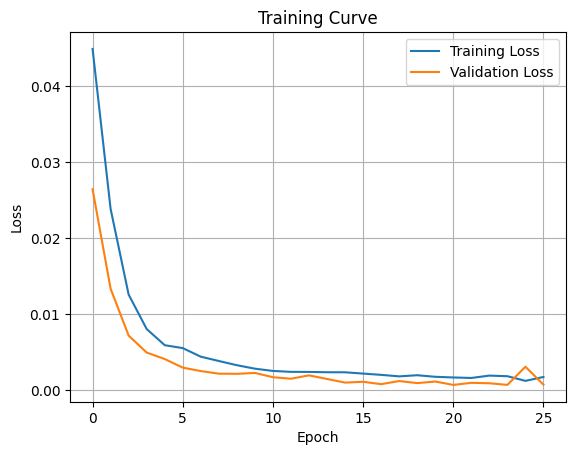

In [28]:
plot_loss_curves(results_history)

### saving model and loading the model

In [51]:
save = False

In [52]:
if save:
    torch.save(model, './trained_models/01_LSTM_model.pth')

In [29]:
model = torch.load('/home/user/Desktop/Pytorch/LSTM_Pytorch/trained_models/01_LSTM_model.pth')

## Test Data

In [30]:
df_test = pd.read_csv('/home/user/Desktop/Pytorch/spiral4_expanded/ep1.csv')
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
BATCH_SIZE = 32

In [31]:
df_test.head()

,Unnamed: 0.1,Unnamed: 0,t,x,y,z,rx,ry,rz,vx,vy,vz,Fx,Fy,Fz,Mx,My,Mz,Case
0,0,0,2.267778,-0.140886,-0.510601,0.072322,-0.000093,0.000043,0.000020,0.000045,0.000072,-0.003916,-0.047292,0.459952,1.659794,0.006255,-0.006227,0.001067,False
1,1,1,2.278596,-0.140869,-0.510647,0.072316,-0.000180,0.000032,0.000020,0.000018,-0.001568,-0.002649,0.102265,0.194572,1.870122,0.028701,-0.011249,0.003291,False
2,2,2,2.286297,-0.140869,-0.510651,0.072312,-0.000226,-0.000003,0.000007,0.000030,-0.000074,-0.003368,0.014108,0.331576,2.677613,0.019793,-0.002007,0.002237,False
3,3,3,2.293303,-0.140888,-0.510676,0.072291,-0.000285,0.000034,-0.000016,0.000030,0.000049,-0.003043,-0.135716,1.062784,4.023598,0.044166,-0.010536,0.004545,False
4,4,4,2.302973,-0.140872,-0.510684,0.072301,-0.000358,0.000059,0.000067,0.000025,-0.000220,-0.002801,0.078930,0.762212,5.413166,0.064926,-0.019468,0.007819,False


In [32]:
df_test = df_test[feature_list]
print(df_test.shape)

(5917, 5)


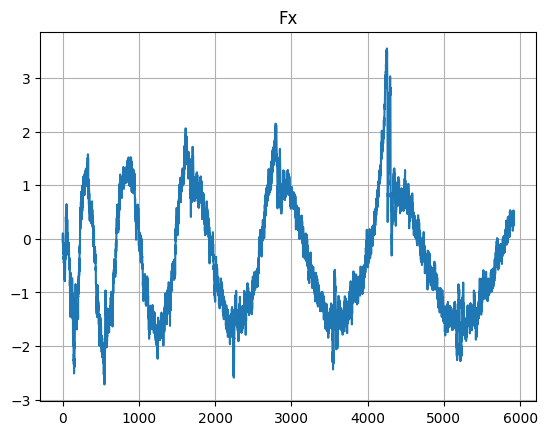

In [34]:
name = 'Fx'
plt.title(name)
plt.plot(df_test[name])
plt.grid()
plt.show()

In [35]:
window = 40
df_test = df_test.rolling(window).mean()
# due to the moving average we the first (window-1) rows become NaN so we remove them
df_test = df_test.loc[window-1:]
print(df_test.shape)
test = np.expand_dims(df_test, axis=1)

x_test, y_test = to_sequence(test, timesteps=TIMESTEP)

print(f"X_test: {x_test.shape} | y_test: {y_test.shape}")

(5878, 5)
X_test: (5828, 50, 5) | y_test: (5828, 5)


In [36]:
x_test_torch, y_test_torch = torch.Tensor(x_test), torch.Tensor(y_test)

test_dataset = TensorDataset(x_test_torch, y_test_torch)

In [37]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Prediction on the Test Set

In [ ]:
def predict(loader, input_data, model):
    model.eval()
    predict = torch.zeros(size=input_data.shape, dtype=torch.float)
    with torch.inference_mode():# torch.no_grad(): 
        for batch_idx, (x_batch, y_batch) in enumerate(loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            yhat = model(x_batch)
            yhat = yhat.cput()
            

    avg_loss = eval_loss / len(loader)
    print('====> Prediction Average loss: {:.6f}'.format(avg_loss))
    return predict